## <font style="color:maroon"> Decision Trees for Regression -- Penguin body mass prediction

In [ ]:
# Import packages and functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics


### <font style = "color:navy"> 1. Read, explore and clean data </font>

In [62]:
# Load the penguins data
penguins = pd.read_csv('palmer_penguins.csv')
print(penguins.shape)
penguins.head()

(344, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [63]:
#Check which columns have missing values and their data types
print(penguins.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB
None


In [64]:
#CHeck how many rows have missing values
penguins.isnull().any(axis = 1).sum()

11

In [65]:
# Drop penguins with missing values
penguins = penguins.dropna()
print(penguins.shape)

(333, 8)


In [66]:

# Create a new data frame with only Gentoo penguins
filter_gentoo = penguins['species'] == 'Gentoo'
gentoo = penguins[filter_gentoo].copy()

# Calculate summary statistics using .describe()
gentoo.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
count,119,119,119.000000,119.000000,119.000000,119.000000,119,119.000000
unique,1,1,NaN,NaN,NaN,NaN,2,NaN
top,Gentoo,Biscoe,NaN,NaN,NaN,NaN,male,NaN
freq,119,119,NaN,NaN,NaN,NaN,61,NaN
mean,NaN,NaN,47.568067,14.996639,217.235294,5092.436975,NaN,2008.067227
std,NaN,NaN,3.106116,0.985998,6.585431,501.476154,NaN,0.789025
min,NaN,NaN,40.900000,13.100000,203.000000,3950.000000,NaN,2007.000000
25%,NaN,NaN,45.350000,14.200000,212.000000,4700.000000,NaN,2007.000000
50%,NaN,NaN,47.400000,15.000000,216.000000,5050.000000,NaN,2008.000000
75%,NaN,NaN,49.600000,15.750000,221.500000,5500.000000,NaN,2009.000000


In [67]:
# Create a matrix of input features with sex, flipper length, and bill length
X = gentoo[['sex', 'flipper_length_mm', 'bill_length_mm']]
X.head()

,sex,flipper_length_mm,bill_length_mm
152,female,211.0,46.1
153,male,230.0,50.0
154,female,210.0,48.7
155,male,218.0,50.0
156,male,215.0,47.6


### <font style = "color:navy">2. Handle categorical data </font>

<span style = "color:orangered"> `DecisionTreeRegressor` only takes numerical values as features, which means features like `sex` and `island` won't work. </span>

Thus, categorical features must be encoded as **dummy variables** that indicate which category the individual falls into.  This encoding is done in `pandas` with `get_dummies`.

In [68]:
# Use pd.get_dummies to convert sex to a binary (0/1) dummy variable
X = pd.get_dummies(X) #For decision trees, no need to set drop_first=True
y = gentoo['body_mass_g']
X.head() #confirm the new columns for the categorical feature 'sex'

,flipper_length_mm,bill_length_mm,sex_female,sex_male
152,211.0,46.1,True,False
153,230.0,50.0,False,True
154,210.0,48.7,True,False
155,218.0,50.0,False,True
156,215.0,47.6,False,True


In [69]:
# 2. Convert all bool columns to integers
X = X.astype(int) #Optional, as scikit-learn will convert them automatically
X.head()

,flipper_length_mm,bill_length_mm,sex_female,sex_male
152,211,46,1,0
153,230,50,0,1
154,210,48,1,0
155,218,50,0,1
156,215,47,0,1


### <font style = "color:navy">3. Split data </font>

In [70]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=152)


### <font style = "color:navy">4. Hyperparameter tuning </font>
Note that instead of the following way of directly assigning hyperparameters, let's perform hyperparameter tuning
```python
regtreeModel = DecisionTreeRegressor(max_depth=2, min_samples_leaf=2);
regtreeModel.fit(X_train, y_train);
```

In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 10, None], 
              'min_samples_leaf': [1, 2, 4]}
grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='r2') #Note that we use 'r2' as the scoring metric for regression problems
# Fit the model to the training data

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Get the best model  
best_regtreeModel = grid_search.best_estimator_


Best parameters: {'max_depth': 3, 'min_samples_leaf': 4}
Best CV score: 0.5814926910492819


### <font style = "color:navy">5. Plotting the tree (the trained model) (optional) </font>

In [72]:
# The print() statement outputs a text version of the regression tree
print(export_text(best_regtreeModel, feature_names=X_train.columns.to_list()))

|--- sex_male <= 0.50
|   |--- flipper_length_mm <= 211.50
|   |   |--- bill_length_mm <= 44.00
|   |   |   |--- value: [4375.00]
|   |   |--- bill_length_mm >  44.00
|   |   |   |--- value: [4597.50]
|   |--- flipper_length_mm >  211.50
|   |   |--- flipper_length_mm <= 213.50
|   |   |   |--- value: [4759.38]
|   |   |--- flipper_length_mm >  213.50
|   |   |   |--- value: [4857.14]
|--- sex_male >  0.50
|   |--- bill_length_mm <= 46.50
|   |   |--- flipper_length_mm <= 219.50
|   |   |   |--- value: [5216.67]
|   |   |--- flipper_length_mm >  219.50
|   |   |   |--- value: [5087.50]
|   |--- bill_length_mm >  46.50
|   |   |--- flipper_length_mm <= 228.50
|   |   |   |--- value: [5481.90]
|   |   |--- flipper_length_mm >  228.50
|   |   |   |--- value: [5775.00]



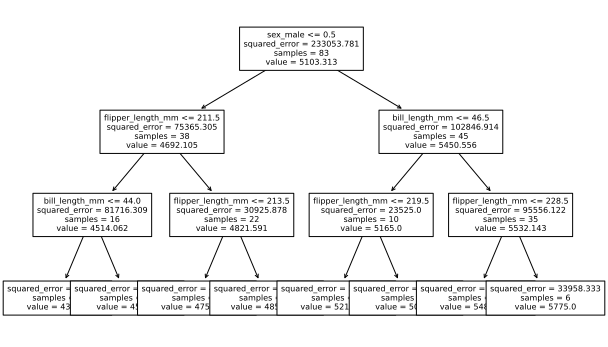

In [73]:
# Using tree.plot_tree() makes a cleaner figure

# Resize the plotting window
plt.figure(figsize=[10, 6])

p = tree.plot_tree(
    best_regtreeModel,
    feature_names=X_train.columns,
    class_names=y_train.unique(),
    filled=False,
    fontsize=8,
)

### <font style = "color:navy">6. Apply the model on `X_test`</font>
1. Predict y values based on `X_test`
2. Prepare a **gentoo_plot** dataframe for creating a scatter plot for observed (`y_test`) and predicted (`y_pred`)body mass values

<img src = "gentoo_plot.png" width = 600, height = 100>

#### 1. Predict y values based on `X_test`

In [74]:
# Add the predictions to the original data set
y_pred = best_regtreeModel.predict(X_test)
y_pred

array([5481.89655172, 5481.89655172, 5775.        , 4759.375     ,
       4597.5       , 4857.14285714, 4375.        , 4857.14285714,
       4857.14285714, 5481.89655172, 4857.14285714, 4857.14285714,
       4857.14285714, 4375.        , 4857.14285714, 4597.5       ,
       5481.89655172, 4597.5       , 4597.5       , 5087.5       ,
       4597.5       , 5775.        , 4857.14285714, 4375.        ,
       5775.        , 5481.89655172, 5481.89655172, 5216.66666667,
       4857.14285714, 5775.        , 5481.89655172, 4857.14285714,
       5481.89655172, 5481.89655172, 4759.375     , 5481.89655172])

In [75]:
print(X_test.shape)
X_test.head()

(36, 4)


,flipper_length_mm,bill_length_mm,sex_female,sex_male
187,220,48,0,1
211,224,50,0,1
241,230,52,0,1
274,212,45,1,0
166,210,45,1,0


In [76]:
print(y_pred.shape)
y_pred[:3].round(2)

(36,)


array([5481.9, 5481.9, 5775. ])

In [77]:
gentoo_plot = X_test.copy()
gentoo_plot.head(3)

,flipper_length_mm,bill_length_mm,sex_female,sex_male
187,220,48,0,1
211,224,50,0,1
241,230,52,0,1


#### 2. Prepare a **gentoo_plot** dataframe for creating a scatter plot for observed and predicted body mass values

In [78]:
# Add the predicted body mass to the gentoo_plot data frame
gentoo_plot['pred_body_mass_g'] = y_pred
gentoo_plot.head(3)

,flipper_length_mm,bill_length_mm,sex_female,sex_male,pred_body_mass_g
187,220,48,0,1,5481.896552
211,224,50,0,1,5481.896552
241,230,52,0,1,5775.000000


In [79]:
# Add the actual body mass to the gentoo_plot data frame
gentoo_plot['actual_body_mass_g'] = y_test
gentoo_plot.head(3)

,flipper_length_mm,bill_length_mm,sex_female,sex_male,pred_body_mass_g,actual_body_mass_g
187,220,48,0,1,5481.896552,5400.0
211,224,50,0,1,5481.896552,5550.0
241,230,52,0,1,5775.000000,5550.0


In [80]:
gentoo_plot = gentoo_plot.drop(columns = ['sex_male'])
gentoo_plot.head(3)

,flipper_length_mm,bill_length_mm,sex_female,pred_body_mass_g,actual_body_mass_g
187,220,48,0,5481.896552,5400.0
211,224,50,0,5481.896552,5550.0
241,230,52,0,5775.000000,5550.0


In [81]:
def nameChange(sex_f):
    return 'Female' if sex_f else 'Male'
gentoo_plot['sex'] = gentoo_plot['sex_female'].apply(nameChange)
gentoo_plot.head(3)

,flipper_length_mm,bill_length_mm,sex_female,pred_body_mass_g,actual_body_mass_g,sex
187,220,48,0,5481.896552,5400.0,Male
211,224,50,0,5481.896552,5550.0,Male
241,230,52,0,5775.000000,5550.0,Male


In [82]:
gentoo_plot = gentoo_plot.drop(columns = ['sex_female'])
gentoo_plot.head(3)

,flipper_length_mm,bill_length_mm,pred_body_mass_g,actual_body_mass_g,sex
187,220,48,5481.896552,5400.0,Male
211,224,50,5481.896552,5550.0,Male
241,230,52,5775.000000,5550.0,Male


### <font style = "color:navy">7. Performance Evaluation </font>

#### Scatter plot 
- to gain visual insights about the prediction results

Text(0.5, 1.0, 'Observed vs. Predicted Body Mass')

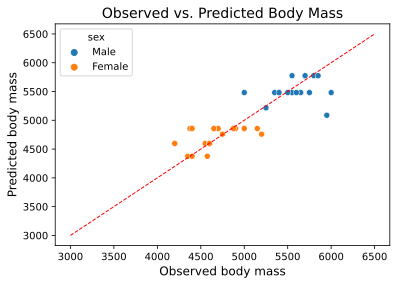

In [83]:
# Plot observed vs. predictions
plt.figure(figsize=(6, 4))
p = sns.scatterplot(data=gentoo_plot, x='actual_body_mass_g', y='pred_body_mass_g', hue='sex')
p.set_xlabel('Observed body mass', fontsize=12)
p.set_ylabel('Predicted body mass', fontsize=12)
#Why are many codes  at the same horizontal ine? 
#Recall that all data points within the same leaf node have the same predicted value
#So the predicted values are constant within each leaf node
#Add a 45-degree line
x = np.linspace(3000, 6500, 100)
y = x
p.plot(x, y, color='red', linestyle='--', linewidth=1)
# Add a title
p.set_title('Observed vs. Predicted Body Mass', fontsize=14)


#### **Performance results:**
- mean squared error (MSE)
- root mean squared error (RMSE)
- coefficient of determination (R-squared)

In [84]:
# Calculate MSE
mse = metrics.mean_squared_error(y_pred, y_test)
print("Mean Squared Error:", mse)

Mean Squared Error: 74791.51098823412


In [85]:
rmse = np.sqrt(mse)
print(f'rmse: {rmse}')

rmse: 273.48036673266716


In [86]:
from sklearn.metrics import r2_score

r_squared_manual = r2_score(y_test, y_pred)
print("R-squared (manual):", r_squared_manual)

R-squared (manual): 0.7385553196078822
